### Visual reasoning using `GPT4o` and 'OWLv2'
This code uses `MuJoCo` simulation with `OWLv2` and `GPT-4o`

In [1]:
import sys,mujoco,time,os,json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')
sys.path.append('../package/gpt_usage/')
sys.path.append('../package/detection_module/')
from mujoco_parser import *
from utility import *
from transformation import *
from gpt_helper import *
from owlv2 import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


#### Parse `UR5e with objects`

In [2]:
xml_path = '../asset/realistic_tabletop/scene_table.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=True)
print ("Done.")

name:[Tabletop] dt:[0.002] HZ:[500]
n_qpos:[47] n_qvel:[42] n_qacc:[42] n_ctrl:[7]

n_body:[31]
 [0/31] [world] mass:[0.00]kg
 [1/31] [base_table] mass:[100.00]kg
 [2/31] [object_table] mass:[100.00]kg
 [3/31] [ur_base] mass:[4.00]kg
 [4/31] [ur_shoulder_link] mass:[3.70]kg
 [5/31] [ur_upper_arm_link] mass:[8.39]kg
 [6/31] [ur_forearm_link] mass:[2.27]kg
 [7/31] [ur_wrist_1_link] mass:[1.22]kg
 [8/31] [ur_wrist_2_link] mass:[1.22]kg
 [9/31] [ur_wrist_3_link] mass:[0.19]kg
 [10/31] [ur_tcp_link] mass:[0.00]kg
 [11/31] [ur_camera_mount] mass:[0.09]kg
 [12/31] [ur_d435i] mass:[0.07]kg
 [13/31] [ur_rg2_gripper_base_link] mass:[0.20]kg
 [14/31] [ur_camera_center] mass:[0.00]kg
 [15/31] [ur_rg2_gripper_finger1_finger_link] mass:[0.01]kg
 [16/31] [ur_rg2_gripper_finger1_inner_knuckle_link] mass:[0.01]kg
 [17/31] [ur_rg2_gripper_finger1_finger_tip_link] mass:[0.01]kg
 [18/31] [ur_rg2_gripper_finger2_finger_link] mass:[0.01]kg
 [19/31] [ur_rg2_gripper_finger2_inner_knuckle_link] mass:[0.01]kg
 

In [3]:
# Joint configuration
joint_names = ['shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
               'wrist_1_joint','wrist_2_joint','wrist_3_joint']
print ("Ready.")

Ready.


In [4]:
# Solve IK to get the initial position 
env.reset()
env.set_p_body(body_name='ur_base',p=np.array([0,0,0.5])) # move UR
q_init,ik_err_stack,ik_info = solve_ik(
    env = env,
    joint_names_for_ik = joint_names,
    body_name_trgt     = 'ur_camera_center',
    q_init       = np.deg2rad([0,0,0,0,0,0]), # ik from zero pose
    p_trgt       = np.array([0.41,0.0,1.2]),
    R_trgt       = rpy2r(np.deg2rad([-135.22,-0.,-90])),
    max_ik_tick  = 5000,
    ik_err_th    = 1e-4,
    ik_stepsize  = 0.1,
    ik_eps       = 1e-2,
    ik_th        = np.radians(1.0),
    verbose      = False,
    reset_env    = False,
    render       = False,
    render_every = 1,
)
print ("Done.")

Done.


Object list:
 [0] obj_name:[obj_redbull]
 [1] obj_name:[obj_coke]
 [2] obj_name:[obj_pringles]
 [3] obj_name:[obj_apple]
 [4] obj_name:[obj_orange]


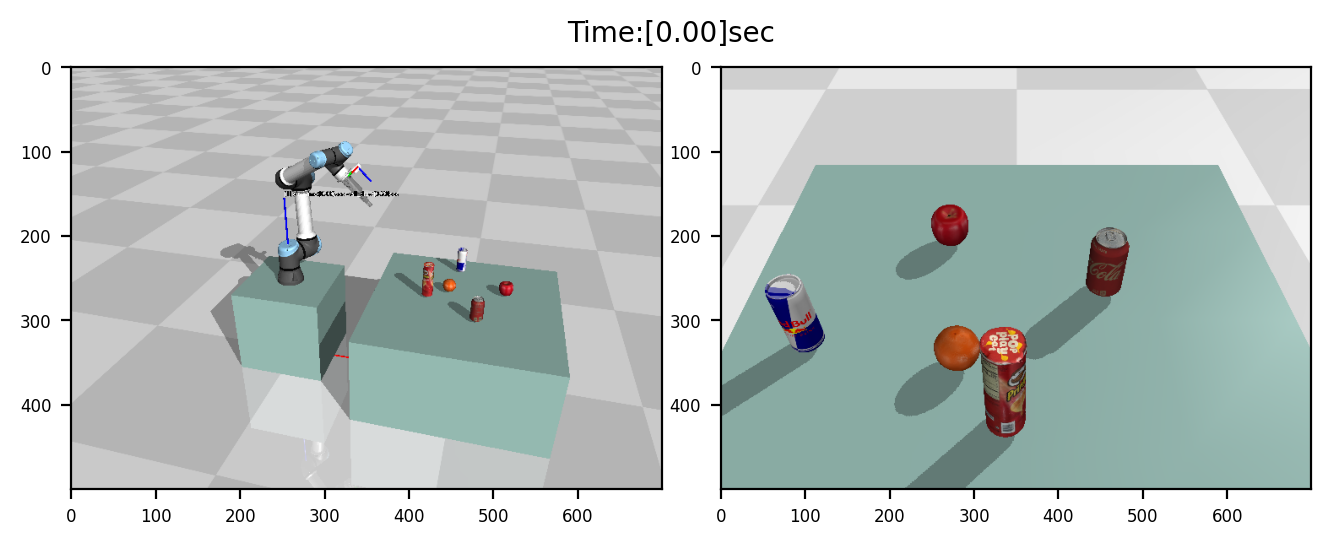

Done.


In [5]:
# np.random.seed(seed=0)
env.reset()
env.init_viewer(
    transparent = False,
    azimuth     = 105,
    distance    = 3.12,
    elevation   = -29,
    lookat      = [0.39, 0.25, 0.43],
)
env.set_p_body(body_name='ur_base',p=np.array([0,0,0.5])) # move UR
env.set_p_body(body_name='object_table',p=np.array([1.0,0,0])) # move table
obj_names = env.get_body_names(prefix='obj_') # object names
n_obj = len(obj_names)
obj_xyzs = sample_xyzs(
    n_obj,
    x_range   = [0.75,1.25],
    y_range   = [-0.4,+0.4],
    z_range   = [0.51,0.51],
    min_dist  = 0.1,
    xy_margin = 0.0
)
print ("Object list:")
for obj_idx in range(n_obj):
    print (" [%d] obj_name:[%s]"%(obj_idx,obj_names[obj_idx]))
    env.set_p_base_body(body_name=obj_names[obj_idx],p=obj_xyzs[obj_idx,:])
    env.set_R_base_body(body_name=obj_names[obj_idx],R=np.eye(3,3))
# Move
qpos = np.radians([0,-90,60,75,90,0])
idxs_step = env.get_idxs_step(joint_names=joint_names)
env.set_qpos_joints(joint_names=joint_names,qpos=q_init)
# Loop
env_state = env.get_state()
while env.is_viewer_alive():
    # Step
    env.step(ctrl=q_init,ctrl_idxs=idxs_step)
    # Grab RGB-D 
    if env.loop_every(tick_every=10):
        p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # z-axis forward
        ego_rgb_img,ego_depth_img,pcd,xyz_img,xyz_img_world = env.get_egocentric_rgbd_pcd(
            p_ego            = p_ego,
            p_trgt           = p_trgt,
            rsz_rate_for_pcd = 1/20, # 1/4
            rsz_rate_for_img = 1/4,
            fovy             = 45, # env.model.cam_fovy[0]
            restore_view     = True,
        )
    # Render
    if env.loop_every(tick_every=10):
        env.plot_T(p=np.array([0,0,0]),R=np.eye(3))
        env.plot_time()
        env.plot_body_T(body_name='ur_camera_center',axis_len=0.1,axis_width=0.005)
        env.render()
    # Plot
    if env.loop_every(tick_every=500): # every 1 second
        # Grab current view
        render_img = env.grab_image(rsz_rate=1/4)
        # Plot
        plt.figure(figsize=(8,3))
        plt.subplot(121)
        plt.imshow(render_img)
        plt.subplot(122)
        plt.imshow(ego_rgb_img)
        plt.suptitle("Time:[%.2f]sec"%(env.get_sim_time()),fontsize=10)
        # plt.tight_layout()
        plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.99)
        plt.show()
env.close_viewer()
print ("Done.")

#### Save the egocentric view `ego_rgb_img` as an image

In [6]:
png_path = './.tmp/mujoco_objects.png'
save_png(ego_rgb_img,png_path,verbose=True)

[./.tmp/mujoco_objects.png] saved.


#### Instantiate `GPT4o` agent

In [7]:
# Instantiate GPT4V helper
GPT = GPT4VchatClass(
    gpt_model = "gpt-4o", #"gpt-4-vision-preview",
    role_msg  = "You are a helpful agent with vision capabilities; do not respond to objects not depicted in images.",
    key_path  = "../key/rilab_key.txt",
)
print ("Ready.")

key_path:[../key/rilab_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

Ready.


#### Ask `GPT4o` to describe the image

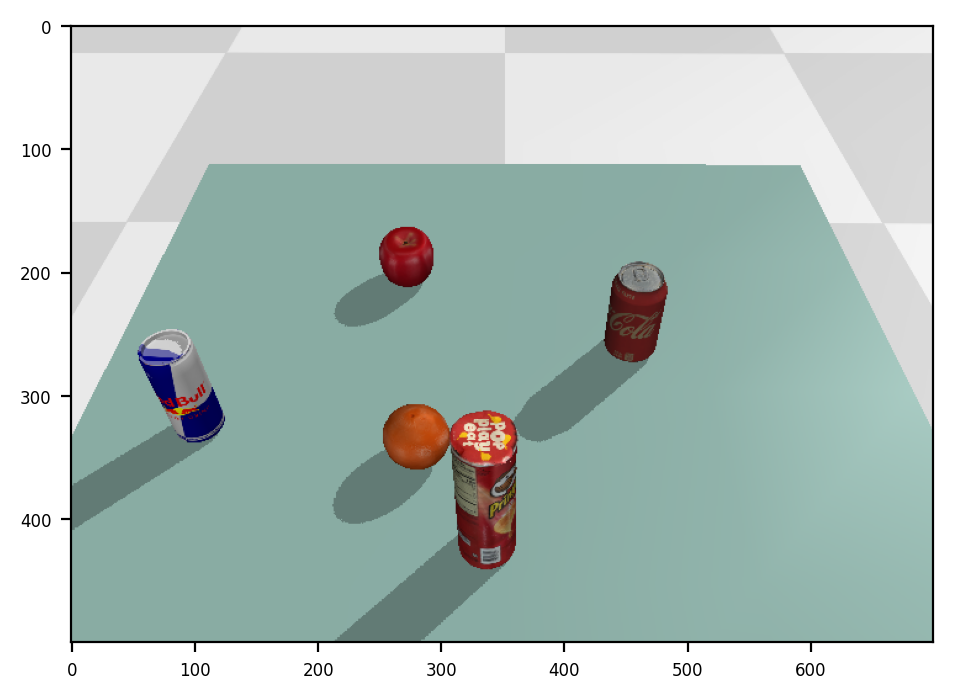

[USER_MSG]

<img1>Describe the image.

[GPT_OUTPUT]

The image shows a light green surface with a checkerboard pattern background. On the surface, there are six objects:

1. A can of Red Bull on the left.
2. An apple next to the center and above the middle.
3. A red can of Coca-Cola positioned on the right.
4. An orange located below the apple.
5. An open tube of Pringles positioned in the center.

Each object is casting a shadow, suggesting a light source above them.

[USER_MSG]


        Could you list down the object names suitable for detection in a json format? 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        

[GPT_OUTPUT]

Certainly! Here is the list of detected objects in the requested JSON format:

```json
{
  "objects": [
    "red bull can",
    "apple fruit",
    "coke can",
    "orange fruit",
    "pringles tube"
  ]
}
```

Done.


In [8]:
# Plot
plt.figure(figsize=(6,4))
plt.imshow(ego_rgb_img)
plt.show()
# Describe the image
GPT.chat(
    user_msg = "<img1>Describe the image.",
    images   = [png_path],
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = False,
    MAX_TOKENS       = 512,
)
# List down the objects in the scene
ret = GPT.chat(
    user_msg = """
        Could you list down the object names suitable for detection in a json format? 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)
print ("Done.")

#### Run open-vocab detection (i.e., `Owlv2`) on the image

object_names:['red bull can', 'apple fruit', 'coke can', 'orange fruit', 'pringles tube']


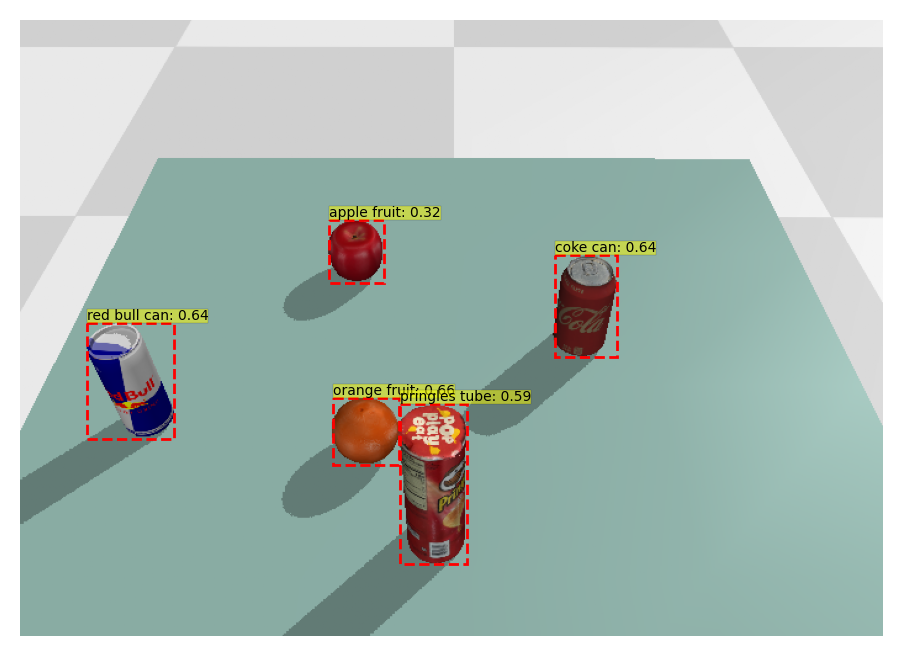

In [9]:
# Parse object names
json_string = ret[ret.find('{'):ret.rfind('}')+1]
data = json.loads(json_string)
object_names = data['objects']
print ("object_names:%s"%(object_names))

# Open-vocab detection
owlvit = Owlv2()
detection_result = owlvit.detect_objects(
    image_path    = png_path,
    object_names  = object_names,
    box_threshold = 0.25,
)

# Plot detection results
plot_detection_result(
    image_path       = png_path,
    detection_result = detection_result,
    figsize          = (6,4),
    fontsize         = 5,
)

#### Get non-overlapping bounding boxes

In [10]:
# Get pcd xyzs of objects
xyz_bboxes = []
for box in detection_result['boxes']: # for each detection boxes
    # First get xyz corresponding to the bbox
    x1,y1,x2,y2 = (box*xyz_img_world.shape[0]/ego_rgb_img.shape[0]).int()
    xyz = xyz_img_world[y1:y2+1,x1:x2+1,:].reshape((-1,3)) # [M x 3]
    xyz_bboxes.append(xyz) # append pcd xyz of bbox
# Exclude overlapping pcd
xyz_bboxes_unique = exclude_overlapping_pcd_within_list(xyz_bboxes)
# Get pcd xyz of objects and center of the objects    
xyz_objects,xyz_centers = [],[]
for xyz in xyz_bboxes_unique:
    # Get xyz of an object excluding the floor
    z_discretized = np.round(xyz[:,2]/0.01)*0.01 # discretized height [M]
    unique,counts = np.unique(z_discretized,return_counts=True)
    k = int(len(unique)*0.5) # for robust floor detection
    top_k_indices = np.argsort(counts)[-k:]
    top_k_unique_values = unique[top_k_indices]
    z_floor = np.min(top_k_unique_values)+0.005 # get z floor
    xyz_object = xyz[xyz[:,2] >= (z_floor)] # get xyz above the floor
    xyz_objects.append(xyz_object) # append pcd xyz above the floor
    # Now, get the center of the object in a xy plane
    xy_object = xyz_object[:,:2] # [M x 2]
    xy_center,radius = fit_xy_circle(xy_object) # center:[2]
    xyz_centers.append(np.append(xy_center,z_floor)) # [3]
print ("Done.")

Done.


#### Get object center points using point clouds

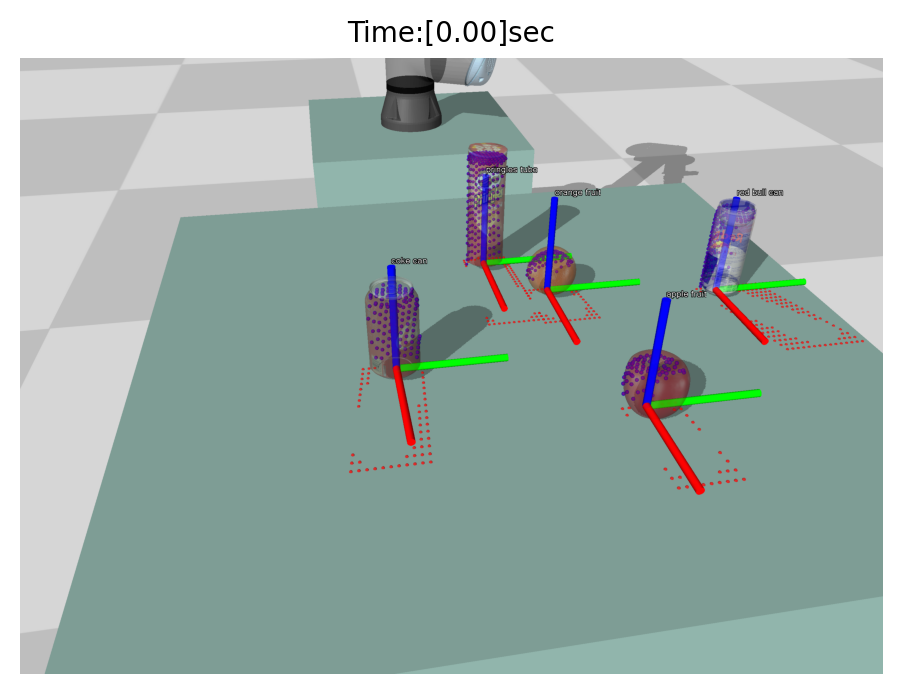

Done.


In [11]:
env.reset()
env.set_state(**env_state)
env.init_viewer(azimuth=170,distance=2.3,elevation=-35,lookat=[0.01,0.1,-0.25],
                transparent=True,maxgeom=100000)
while env.is_viewer_alive():
    # Step
    env.step(ctrl=q_init,ctrl_idxs=idxs_step)
    # Render
    if env.loop_every(tick_every=10):
        for idx in range(detection_result['n']):
            env.plot_spheres(ps=xyz_bboxes[idx],r=0.002,rgba=(1,0,0,0.5))
            env.plot_spheres(ps=xyz_objects[idx],r=0.0025,rgba=(0,0,1,0.5))
            env.plot_T(p=xyz_centers[idx],R=np.eye(3),plot_axis=True,axis_len=0.15,axis_width=0.005)
            object_name = detection_result['object_names'][detection_result['labels'][idx]]
            env.plot_text(p=xyz_centers[idx]+np.array([0,0,0.15]),label='%s'%(object_name))
        env.render()
    # Plot
    if env.loop_every(tick_every=5000): # every 10 second
        # Grab current view
        render_img = env.grab_image(rsz_rate=1)
        # Plot
        plt.figure(figsize=(6,4))
        plt.imshow(render_img)
        plt.title("Time:[%.2f]sec"%(env.get_sim_time()),fontsize=10)
        plt.axis('off')
        plt.show()
env.close_viewer()
print ("Done.")

In [12]:
# Store current GPT message
gpt_state = GPT.get_state()
print ("GPT state ready.")

GPT state ready.


#### Little bit of `common-sense` inference using `GPT4o`

In [13]:
# Set GPT state
GPT.set_state(state=gpt_state)
ret = GPT.chat(
    user_msg = """
        Could you recommend one thing on the table that I can eat?
        BTW, I am very tired. It would be better if you can give me reasons as well.
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)

[USER_MSG]


        Could you recommend one thing on the table that I can eat?
        BTW, I am very tired. It would be better if you can give me reasons as well.
        

[GPT_OUTPUT]

Based on the items on the table, I recommend eating the orange. 

Here are the reasons:

1. **Energy Boost**: Oranges are a great source of natural sugars and carbohydrates, which can provide a quick energy boost when you're feeling tired.

2. **Vitamin C**: Oranges are rich in vitamin C, which helps support the immune system and can help fight off fatigue.

3. **Hydration**: Oranges have high water content, helping you stay hydrated, which is important when you're feeling tired.

4. **Natural and Healthy**: Unlike the other items (Red Bull, Coke, Pringles), the orange is a natural fruit with fewer artificial ingredients and preservatives, making it a healthier option.

Enjoy your snack and hope it helps you feel more energized!